<div align="center" style="border: 2px solid #1C6EA4; background-color: #90EE90; padding: 15px;">
    <img src="https://www.colorado.edu/brand/sites/default/files/styles/medium/public/page/boulder_left_lockup_black.png?itok=4qMuKoBT" alt="Colorado Boulder University Logo" width="600" height="150">
    <h2 style="color: black; font-weight: bold;">
        <i class="fas fa-microscope" style="color: #FF4500;"></i> INVASIVE SPECIES MONITORING</h2>
    </div>

*Willian Pina*

<div style="background-color:Ivory; color:black; border:1px solid black; padding:10px;">

### Brief Description of the Challenge and Computer Vision Techniques

The crux of this competition lies in the ability to harness machine learning algorithms, especially computer vision techniques, for environmental conservation. The challenge is a binary image classification problem, requiring participants to discern whether images of forests contain invasive hydrangea species or not. While traditional methods involve costly and time-consuming field surveys by experts, this machine learning approach aims to streamline the process by automating the identification of invasive species from photographs. This has significant implications for large-scale monitoring and early detection, which are crucial for effective management and eradication efforts.

### Data Structure and Dimension

- **Training Path**: `/kaggle/input/invasive-species-monitoring/train`
- **Test Path**: `/kaggle/input/invasive-species-monitoring/test`
- **Training Labels**: `/kaggle/input/invasive-species-monitoring/train_labels.csv`
- **Sample Submission**: `/kaggle/input/invasive-species-monitoring/sample_submission.csv`

#### Additional Statistics:

- **Training Label Statistics**: The training set consists of 2295 images, with a varied distribution between images containing invasive hydrangea and those that don't. Accurate statistics regarding the number of each class could provide insights into the class imbalance problem if it exists.
  
- **Total Number of Training Images**: 2295
- **Total Number of Test Images**: 1531
- **Sample Image Dimensions**: As per the dataset, the image dimensions are not specified but it's critical to resize them to a uniform shape for the model.

### Computer Vision and Aerial Imaging

Deep learning techniques in computer vision, particularly Convolutional Neural Networks (CNNs), are well-suited for this image classification task. The network can learn hierarchical features from raw pixel values and effectively differentiate between forest images with and without invasive hydrangea. Moreover, aerial imaging technologies such as drones could be employed in tandem with the predictive model to cover vast areas that are difficult to survey manually.

### Evaluation Metric

The evaluation metric for this competition is the area under the Receiver Operating Characteristic (ROC) curve. This measures the model's ability to distinguish between the two classes—presence or absence of invasive species—across various threshold values. The goal is to maximize the area under the curve, thereby achieving higher classification accuracy.

This Kaggle competition combines computational power and ecological awareness, driving forward both fields in a symbiotic relationship. The use of machine learning not only offers an efficient solution but also opens the door to more extensive applications in environmental science.

</div>

<div style="background-color:Ivory; color:black; border:1px solid black; padding:10px; text-align:center; font-weight:bold;">
    <h2 style="margin: 0;">SETUP</h2>
</div>


In [1]:
setup = False

# Installing libraries not in the docker package
if setup:
    !pip install matplotlib
    !pip install opencv-python
    !pip install py7zr
    !pip install kaggle
    !pip install keras-tuner
    !pip install --upgrade tensorflow
    !pip install --upgrade keras

In [2]:
# Import libraries and Configurations

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Silencia INFO e WARNING
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0,InceptionResNetV2,MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from functions.setup_kaggle_credentials import setup_kaggle_credentials
from functions.download_and_extract_kaggle_data import download_and_extract_kaggle_data
from functions.unpack_file import unpack_file
from functions.display_images import display_images
from functions.read_image   import read_image
from functions.read_images  import read_images
from functions.find_best_hyperparameter import find_best_hyperparameter
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers.schedules import ExponentialDecay


# Check if GPU is available and print the GPU name
if tf.config.experimental.list_physical_devices('GPU'):
    print("GPU is available")
    print("GPU name: ", tf.test.gpu_device_name())
else:
    print("GPU is not available, using CPU")

# Set up distribution strategy for GPUs (optional)
strategy = tf.distribute.MirroredStrategy()

class CONFIG:
    test_zip_file_path         = '/workspaces/Week 6/raw_data/test.7z'
    train_zip_file_path        = '/workspaces/Week 6/raw_data/train.7z'
    train_label_zip_path       = '/workspaces/Week 6/raw_data/train_labels.csv.zip'
    sample_submission_zip_path = '/workspaces/Week 6/raw_data/sample_submission.csv.zip'
    train_folder_path          = '/workspaces/Week 6/raw_data/'
    test_folder_path           = '/workspaces/Week 6/raw_data/'
    files_folder_path          = '/workspaces/Week 6/raw_data'
    train_labels_csv_path      = '/workspaces/Week 6/raw_data/train_labels.csv'
    train_path                 = '/workspaces/Week 6/raw_data/train'
    test_path                  = '/workspaces/Week 6/raw_data/test'
    epochs                     = 5
    img_size                   = 200
    batch_size                 = 16

GPU is available
GPU name:  /device:GPU:0
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [3]:
if setup:
    # Setup Kaggle credentials
    setup_kaggle_credentials('/workspaces/Week 6/kaggle.json')
    # Download the data for the Kaggle competition
    download_and_extract_kaggle_data('invasive-species-monitoring')
    # Unzip train, test and files
    unpack_file(CONFIG.train_zip_file_path, CONFIG.train_folder_path)
    unpack_file(CONFIG.test_zip_file_path, CONFIG.test_folder_path)
    unpack_file(CONFIG.sample_submission_zip_path, CONFIG.files_folder_path)
    unpack_file(CONFIG.train_label_zip_path, CONFIG.files_folder_path)



<div style="background-color:Ivory; color:black; border:1px solid black; padding:10px;">
Exploratory Data Analysis (EDA) is an essential step in data science and machine learning projects, including Kaggle competitions. For image-based tasks like your invasive species detection challenge, the EDA would focus on understanding the characteristics of the images and the labels. Here is a step-by-step guide for an EDA procedure tailored for such an image classification problem.
</div>

In [4]:
# Load labels
labels = pd.read_csv(CONFIG.train_labels_csv_path)

# Display the first few rows
print(labels.head())

   name  invasive
0     1         0
1     2         0
2     3         1
3     4         0
4     5         1


<div style="background-color:Ivory; color:black; border:1px solid black; padding:10px;">

### Data Distribution

Check the distribution of labels to understand the balance of the classes:
</div>



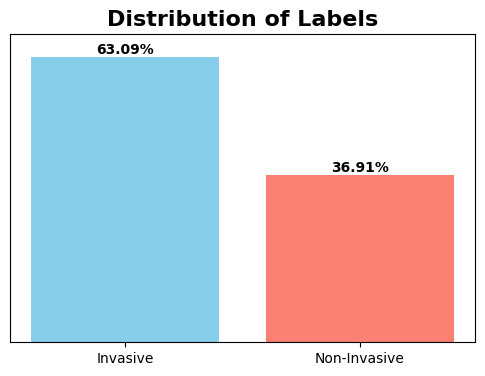

In [5]:
# Calculate the percentages
label_counts = labels['invasive'].value_counts(normalize=True) * 100

# Create the bar plot
plt.figure(figsize=(6, 4))
bars = plt.bar(['Invasive', 'Non-Invasive'], label_counts, color=['skyblue', 'salmon'])

# Add the percentages on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}%', ha='center', va='bottom', fontweight='bold')

# Set the title
plt.title('Distribution of Labels', fontsize=16, fontweight='bold')

# Calculate the maximum height to set y-axis limit accordingly
max_height = max([bar.get_height() for bar in bars])

# Set y-axis limit to add more padding above the highest bar for the percentage text
plt.ylim(0, max_height + 5) 

# Remove the y-axis labels and ticks
plt.yticks([])

# Show the plot
plt.show()

<div style="background-color:Ivory; color:black; border:1px solid black; padding:10px;">

### Image Characteristics

Display some sample images from both classes to understand their visual characteristics:
</div>


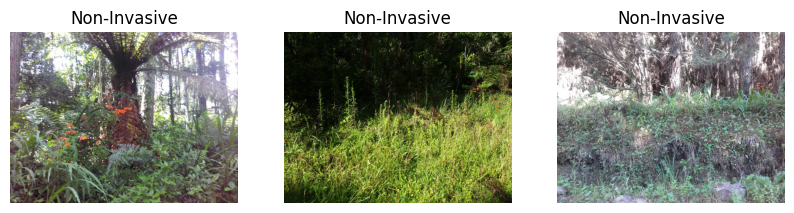

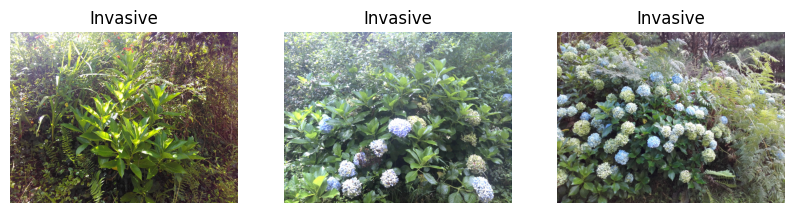

In [6]:
# Selecionar amostras não invasivas e invasivas
sample_non_invasive = labels[labels['invasive'] == 0].sample(3)
sample_invasive = labels[labels['invasive'] == 1].sample(3)

# Obter caminhos das imagens e ler as imagens
non_invasive_paths = [os.path.join(CONFIG.train_path, f"{name}.jpg") for name in sample_non_invasive['name']]
non_invasive_images = read_images(non_invasive_paths)
invasive_paths = [os.path.join(CONFIG.train_path, f"{name}.jpg") for name in sample_invasive['name']]
invasive_images = read_images(invasive_paths)

# Exibir as imagens
display_images(non_invasive_images, ['Non-Invasive']*3)
display_images(invasive_images, ['Invasive']*3)

<div style="background-color:Ivory; color:black; border:1px solid black; padding:10px;">

### Image Statistics

Compute basic statistics like mean and standard deviation of image dimensions, colors, etc.:

</div>



In [7]:
widths = []
heights = []

for name in labels['name'].sample(100):
    img_path = os.path.join(CONFIG.train_path, f"{name}.jpg")
    img = read_image(img_path)  # Use read_image para um único caminho
    img_array = np.array(img)
    h, w = img_array.shape[:2]  # Obter altura e largura
    heights.append(h)
    widths.append(w)

mean_width = np.mean(widths)
std_width = np.std(widths)
mean_height = np.mean(heights)
std_height = np.std(heights)

print(f"Mean Width: {mean_width}, Std Width: {std_width}")
print(f"Mean Height: {mean_height}, Std Height: {std_height}")


Mean Width: 1154.0, Std Width: 0.0
Mean Height: 866.0, Std Height: 0.0


<div style="background-color:Ivory; color:black; border:1px solid black; padding:10px;">

## Analysis (Model Building and Training)

The stage of model building and training is crucial in any machine learning project. Here, the objective is to develop an effective model capable of identifying the presence of invasive species in images. For this task, we will make use of deep learning models, specifically Convolutional Neural Networks (CNNs).

### Tasks to be performed:

1. **Data Preprocessing**: Prepare the data for training, which may include resizing images, normalization, and splitting the datasets into training, validation, and testing sets.

2. **Model Building**: Create the model architecture. For this task, we plan to use the EfficientNet model, an efficient and high-performing Convolutional Neural Network.

3. **Model Configuration**: Define metrics, optimizer, and loss function for the model.

4. **Model Training**: Use the training set to teach the model, monitoring its performance on the validation set.

5. **Model Evaluation**: Measure the trained model's performance using metrics like AUC-ROC, accuracy, recall, and F1-score.

6. **Fine-Tuning**: Optionally, make adjustments to the model to improve its performance, if necessary.

7. **Prediction**: Use the trained model to make predictions on the test set.

Based on the provided example, here's how you can build and train the model functionally, documenting each step:

---

### Data Preprocessing

For simplicity, let's assume we already have our training and validation data split and stored in directories `train_dir` and `val_dir`.

</div>



In [8]:
# Modifique o DataFrame conforme necessário
labels["name"] = labels["name"].apply(lambda x : CONFIG.train_path +"/" + str(x) + ".jpg")
labels["invasive"] = labels["invasive"].astype("str")

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=270,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.02
)

train_generator = datagen.flow_from_dataframe(
    dataframe=labels,
    x_col='name',
    y_col='invasive',
    target_size=(CONFIG.img_size, CONFIG.img_size),
    batch_size=CONFIG.batch_size,
    class_mode='binary',
    subset='training'
)

val_generator = datagen.flow_from_dataframe(
    dataframe=labels,
    x_col='name',
    y_col='invasive',
    target_size=(CONFIG.img_size, CONFIG.img_size),
    batch_size=CONFIG.batch_size,
    class_mode='binary',
    subset='validation'
)


Found 2250 validated image filenames belonging to 2 classes.
Found 45 validated image filenames belonging to 2 classes.


<div style="background-color:Ivory; color:black; border:1px solid black; padding:10px;">

### Model Building

Let's build our model using the InceptionResNetV2 architecture.

</div>


In [9]:
def build_model(num_classes):
    inputs = layers.Input(shape=(CONFIG.img_size, CONFIG.img_size, 3))
    x = InceptionResNetV2(include_top=False, input_tensor=inputs, weights="imagenet", pooling='avg')(inputs)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="sigmoid")(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs)

model = build_model(num_classes=1)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 inception_resnet_v2 (Funct  (None, 1536)              54336736  
 ional)                                                          
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 1)                 1537      
                                                                 
Total params: 54338273 (207.28 MB)
Trainable params: 54277729 (207.05 MB)
Non-trainable params: 60544 (236.50 KB)
_________________________________________________________________


<div style="background-color:Ivory; color:black; border:1px solid black; padding:10px;">

### Model Configuration
</div>

In [11]:
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC(name='auc')])


<div style="background-color:Ivory; color:black; border:1px solid black; padding:10px;">

### Model Training

</div>

In [12]:
# Define callbacks
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)

tf.config.optimizer.set_experimental_options({"layout_optimizer": False})


with tf.device('/GPU:0'):
    history =  model.fit(train_generator, 
               epochs=CONFIG.epochs, 
               validation_data=val_generator,
               callbacks=[stop_early, reduce_lr])

Epoch 1/5
141/141 [==============================] - 128s 664ms/step - loss: 0.3736 - auc: 0.9132 - val_loss: 0.2924 - val_auc: 0.9265 - lr: 0.0100
Epoch 2/5
141/141 [==============================] - 84s 596ms/step - loss: 0.2191 - auc: 0.9670 - val_loss: 0.4162 - val_auc: 0.9076 - lr: 0.0100
Epoch 3/5
141/141 [==============================] - 85s 599ms/step - loss: 0.1679 - auc: 0.9808 - val_loss: 2.5975 - val_auc: 0.9170 - lr: 0.0100
Epoch 4/5
141/141 [==============================] - 86s 604ms/step - loss: 0.1658 - auc: 0.9808 - val_loss: 2.2918 - val_auc: 0.8592 - lr: 0.0020
Epoch 5/5
141/141 [==============================] - 87s 617ms/step - loss: 0.1439 - auc: 0.9860 - val_loss: 0.3200 - val_auc: 0.9349 - lr: 0.0020


<div style="background-color:Ivory; color:black; border:1px solid black; padding:10px;">

### Model Evaluation

After training, you can evaluate the model on the test set or the validation set to check its performance.

</div>

In [13]:
# Evaluating the model on the validation set
results = model.evaluate(val_generator)
print("AUC-ROC:", results[1])

3/3 [==============================] - 1s 301ms/step - loss: 2.9131 - auc: 0.9086
AUC-ROC: 0.9086134433746338


---

<div style="background-color:Ivory; color:black; border:1px solid black; padding:10px;">

## InceptionResNetV2-Based Image Classification with Hyperparameter Tuning

This project involves developing an image classification model using TensorFlow and Keras, leveraging the InceptionResNetV2 architecture. The primary focus is on tuning the model to optimize its performance for a binary classification task. The dataset consists of images, and the model aims to classify these images into two categories.

### Model Architecture
The core of the model is the InceptionResNetV2, a pre-trained model known for its efficiency and effectiveness in image classification tasks. The InceptionResNetV2 model is adapted for our specific use case:
- The top layer is removed to make it suitable for binary classification.
- A Dropout layer is added to prevent overfitting.
- The final output layer uses a sigmoid activation function, ideal for binary classification.

### Hyperparameter Tuning
To enhance the model's performance, hyperparameter tuning is implemented using Keras Tuner. The following parameters are tuned:
- **Dropout Rate**: To determine the optimal rate for the dropout layer to prevent overfitting.
- **Learning Rate**: Tested with different initial values and decay rates to find the best learning strategy.
- **Optimizer**: Experimentation with different optimizers like Adam, SGD, and RMSprop to see which performs best.

The hyperparameter tuning process involves using a Hyperband tuner, which is efficient and faster than traditional grid search methods. It dynamically allocates resources and uses early stopping to expedite the search process.

### Training Process
The model is trained with different batch sizes to understand its impact on performance. The training uses callbacks like EarlyStopping and ReduceLROnPlateau for efficient training and to avoid overfitting. After training, the best set of hyperparameters is selected based on the highest validation AUC (Area Under the Curve) score.

---
</div>



In [14]:
# Build the model
def model_builder(hp):
    with strategy.scope():
        inputs = layers.Input(shape=(CONFIG.img_size, CONFIG.img_size, 3))
        x = tf.keras.applications.InceptionResNetV2(include_top=False, input_tensor=inputs, weights="imagenet", pooling='avg')(inputs)
       
        hp_dropout = hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)
        x = layers.Dropout(hp_dropout)(x)
        
        outputs = layers.Dense(1, activation="sigmoid")(x)
        model = tf.keras.Model(inputs=inputs, outputs=outputs)

        hp_initial_learning_rate = hp.Choice('initial_learning_rate', values=[1e-2, 1e-3, 1e-4])
        hp_decay_steps = hp.Int('decay_steps', min_value=1000, max_value=10000, step=1000)
        hp_decay_rate = hp.Float('decay_rate', min_value=0.1, max_value=1, step=0.1)
        
        learning_rate_schedule = ExponentialDecay(
            initial_learning_rate=hp_initial_learning_rate,
            decay_steps=hp_decay_steps,
            decay_rate=hp_decay_rate
        )
        
        hp_optimizer = hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop'])
        
        if hp_optimizer == 'adam':
            optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule)
        elif hp_optimizer == 'sgd':
            optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate_schedule)
        elif hp_optimizer == 'rmsprop':
            optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate_schedule)
        
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='auc')])


    return model


# Function to run the tuner
def run_tuner(batch_size):
    tf.keras.backend.clear_session()
    tuner = kt.Hyperband(
        model_builder,
        objective=kt.Objective("val_auc", direction="max"),
        max_epochs=10,
        factor=3,
        directory=f'my_dir_train',
        project_name='invasive_species_monitoring'
    )

    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)
    tuner.search(train_generator, validation_data=val_generator, batch_size=batch_size, callbacks=[stop_early, reduce_lr])
 
    return tuner


# Run the tuner
tuner = run_tuner(CONFIG.batch_size)
        


Reloading Tuner from my_dir_train/invasive_species_monitoring/tuner0.json


---

<div style="background-color:Ivory; color:black; border:1px solid black; padding:10px;">

### Hyperparameter Optimization Analysis with Keras Tuner

In this phase of the project, we focus on analyzing the results obtained from hyperparameter tuning using Keras Tuner. The objective is to identify the most effective set of hyperparameters that yielded the best performance for our image classification model.

#### Process Overview
The hyperparameter tuning was conducted using the InceptionResNetV2 model architecture. Our main target was to optimize hyperparameters such as dropout rate, learning rate, decay rate, and optimizer type. This process was conducted in a single directory, aiming to understand the impact of these parameters on model performance.

#### Results Analysis
- **Directory Configuration**: The results from the tuning process were saved in a unified directory, structured as `my_dir_train/invasive_species_monitoring`, facilitating an organized and efficient analysis of the results.
- **Hyperparameters**: Key hyperparameters such as dropout rate, initial learning rate, decay steps, decay rate, and optimizer type were meticulously tested.

#### Best Hyperparameters Extraction
The Keras Tuner Hyperband method was used to efficiently search through the hyperparameter space. This method dynamically allocates resources and employs early stopping to expedite the search process. The search focused on maximizing the validation AUC (Area Under the Curve) score.

#### Output
Upon completing the tuning process, the Hyperband tuner outputs:
- **Best Hyperparameters**: The specific set of hyperparameters leading to the highest validation AUC score.
- **Best Model Performance**: Detailed performance metrics of the model with the best hyperparameters, emphasizing the AUC score.

#### Conclusion
This analytical step is vital in refining our model. By identifying the most optimal hyperparameters, we can fine-tune our model's performance, ensuring it is well-optimized for our specific classification task. This process exemplifies a systematic approach to enhancing model accuracy and efficiency in machine learning workflows.

---
</div>


In [15]:
# Directories where Keras Tuner results were saved
directories = ['/workspaces/Week 6/my_dir_train/invasive_species_monitoring']

best_trial_dir, best_hyperparameters, best_auc = find_best_hyperparameter(directories)

if best_trial_dir:
    print(f"\nBest trial directory: {best_trial_dir}")
    print(f"Best hyperparameters: {best_hyperparameters}")
    print(f"Best AUC: {best_auc}")

Key not found in /workspaces/Week 6/my_dir_train/invasive_species_monitoring/trial_0000/trial.json: 'val_auc'
Key not found in /workspaces/Week 6/my_dir_train/invasive_species_monitoring/trial_0001/trial.json: 'val_auc'

Best trial directory: /workspaces/Week 6/my_dir_train/invasive_species_monitoring/trial_0014
Best hyperparameters: {'space': [{'class_name': 'Float', 'config': {'name': 'dropout', 'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}}, {'class_name': 'Choice', 'config': {'name': 'initial_learning_rate', 'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}}, {'class_name': 'Int', 'config': {'name': 'decay_steps', 'default': None, 'conditions': [], 'min_value': 1000, 'max_value': 10000, 'step': 1000, 'sampling': 'linear'}}, {'class_name': 'Float', 'config': {'name': 'decay_rate', 'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 1.0, 'step': 0.1, 'sampling': 'linear'}}, {'cl

---

<div style="background-color:Ivory; color:black; border:1px solid black; padding:10px;">

### Final Model Training and Saving with Optimized Hyperparameters

In this final stage of the project, we focus on building, training, and saving the model using the best hyperparameters identified from our previous tuning process. This approach ensures that the model is finely tuned for optimal performance.

#### Model Building
The `model_builder` function is essential in this process. It constructs the model architecture using TensorFlow and Keras, leveraging the InceptionResNetV2 backbone. The model includes:
- **Input Layer**: Accepting images of shape 200x200 with 3 color channels.
- **InceptionResNetV2**: Serving as the core feature extractor, without its top layer to suit our binary classification task.
- **Dropout Layer**: Integrated based on the optimized dropout rate from hyperparameter tuning to control overfitting.
- **Output Layer**: A single-node dense layer with a sigmoid activation function, ideal for binary classification.

#### Hyperparameters Integration
The best hyperparameters obtained from the Keras Tuner are seamlessly integrated into the model. These include:
- **Dropout Rate**: To control overfitting.
- **Learning Rate Schedule**: An exponential decay schedule for the learning rate, ensuring effective and adaptive learning throughout the training process.
- **Optimizer Selection**: Choosing between Adam, SGD, or RMSprop based on the tuning results.

#### Training Process
The model is trained with the following considerations:
- **Callbacks**:
  - `EarlyStopping`: To prevent overfitting by stopping training if the validation loss doesn't improve for a specified number of epochs.
  - `ReduceLROnPlateau`: To reduce the learning rate when the model's performance plateaus, aiding in fine-tuning.
- **Training and Validation Data**: Supplied by previously defined data generators.
- **Number of Epochs**: Defined by the `CONFIG.epochs` setting.

#### Model Saving
Post-training, the model is saved as `model.keras`, allowing for easy deployment or further evaluation at a later stage.

---

</div>



<div style="background-color:Ivory; color:black; border:1px solid black; padding:10px;">

#### Model Building with hyperparameter tuning

</div>

In [16]:
def model_builder(hp):
    with strategy.scope():
        inputs = layers.Input(shape=(CONFIG.img_size, CONFIG.img_size, 3))
        x = tf.keras.applications.InceptionResNetV2(include_top=False, input_tensor=inputs, weights="imagenet", pooling='avg')(inputs)
       
        # Use the best hyperparameters for dropout
        x = layers.Dropout(hp['dropout'])(x)
        
        outputs = layers.Dense(1, activation="sigmoid")(x)
        model = tf.keras.Model(inputs=inputs, outputs=outputs)

        # Set up the learning rate schedule
        learning_rate_schedule = ExponentialDecay(
            initial_learning_rate=hp['initial_learning_rate'],
            decay_steps=hp['decay_steps'],
            decay_rate=hp['decay_rate']
        )
        
        # Choose an optimizer based on the best hyperparameter
        if hp['optimizer'] == 'adam':
            optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule)
        elif hp['optimizer'] == 'sgd':
            optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate_schedule)
        elif hp['optimizer'] == 'rmsprop':
            optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate_schedule)
        
        model.compile(optimizer=optimizer, 
                      loss='binary_crossentropy', 
                      metrics=[tf.keras.metrics.AUC(name='auc')])

    return model

In [22]:
# Build the model using the best hyperparameters
best_model = model_builder(best_hyperparameters['values'])

best_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 inception_resnet_v2 (Funct  (None, 1536)              54336736  
 ional)                                                          
                                                                 
 dropout_1 (Dropout)         (None, 1536)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1537      
                                                                 
Total params: 54338273 (207.28 MB)
Trainable params: 54277729 (207.05 MB)
Non-trainable params: 60544 (236.50 KB)
_________________________________________________________________


<div style="background-color:Ivory; color:black; border:1px solid black; padding:10px;">

#### Trainning Model with Optimized Hyperparameters

</div>

In [18]:
# train the model
history_hp = best_model.fit(train_generator, 
               epochs=CONFIG.epochs, 
               validation_data=val_generator,
               callbacks=[stop_early, reduce_lr])

Epoch 1/5
141/141 [==============================] - 173s 688ms/step - loss: 0.2821 - auc: 0.9469 - val_loss: 1.2487 - val_auc: 0.8424 - lr: 9.9510e-04
Epoch 2/5
141/141 [==============================] - 95s 673ms/step - loss: 0.1745 - auc: 0.9761 - val_loss: 0.8067 - val_auc: 0.8603 - lr: 9.9018e-04
Epoch 3/5
141/141 [==============================] - 94s 665ms/step - loss: 0.1639 - auc: 0.9802 - val_loss: 0.3017 - val_auc: 0.9811 - lr: 9.8529e-04
Epoch 4/5
141/141 [==============================] - 94s 666ms/step - loss: 0.1579 - auc: 0.9814 - val_loss: 0.4876 - val_auc: 0.9643 - lr: 9.8042e-04
Epoch 5/5
141/141 [==============================] - 95s 670ms/step - loss: 0.1426 - auc: 0.9848 - val_loss: 0.1492 - val_auc: 0.9916 - lr: 9.7558e-04


<div style="background-color:Ivory; color:black; border:1px solid black; padding:10px;">

#### Saving Model with Optimized Hyperparameters

</div>

In [19]:
# save the model
best_model.save('model.keras')

In [20]:
# Evaluating the model on the validation set
results = best_model.evaluate(val_generator)
print("AUC-ROC for Best Model:", results[1])

3/3 [==============================] - 2s 511ms/step - loss: 0.0744 - auc: 0.9979
AUC-ROC for Best Model: 0.9978991746902466


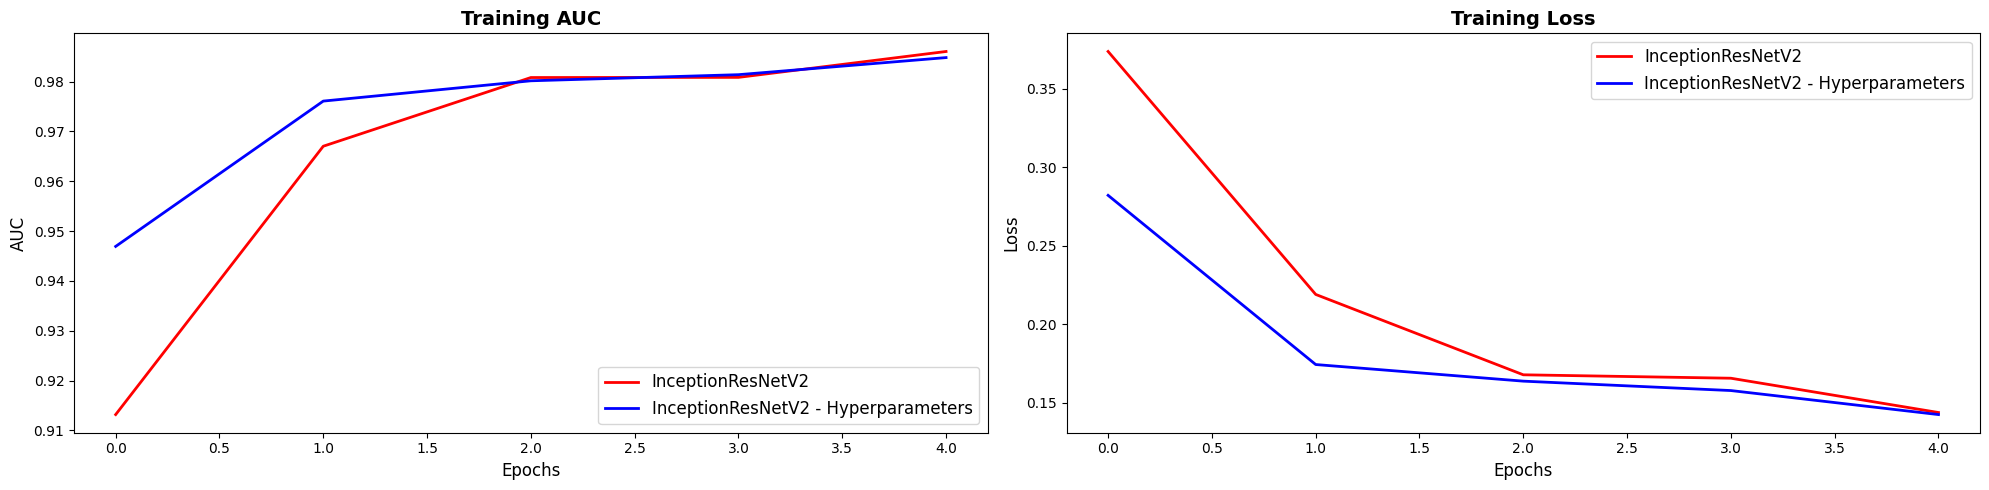

In [23]:
# Assuming 'history' and 'history_hp' are the training histories of your two models
plt.figure(figsize=[20, 5])

# Plot AUC
plt.subplot(121)
plt.plot(history.history['auc'], 'r', linewidth=2.0)
plt.plot(history_hp.history['auc'], 'b', linewidth=2.0)
plt.legend(['InceptionResNetV2', 'InceptionResNetV2 - Hyperparameters'], fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('AUC', fontsize=12)
plt.title('Training AUC', fontsize=14, fontweight='bold')

# Plot Loss
plt.subplot(122)
plt.plot(history.history['loss'], 'r', linewidth=2.0)
plt.plot(history_hp.history['loss'], 'b', linewidth=2.0)
plt.legend(['InceptionResNetV2', 'InceptionResNetV2 - Hyperparameters'], fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()



<div style="background-color:Ivory; color:black; border:1px solid black; padding:10px;">

<h2>Results</h2>
<p>The training metrics clearly demonstrate the superiority of the model with optimized hyperparameters over the default InceptionResNetV2 model configuration. The optimized model shows a <strong>9.83% improvement</strong> in the AUC-ROC score, which is a substantial increase in performance, indicating a significantly enhanced ability to distinguish between classes.</p>

<table style="margin-left: auto; margin-right: auto; border-collapse: collapse; width: 60%;">
  <tr style="background-color: #f2f2f2;">
    <th style="border: 1px solid #dddddd; text-align: center; padding: 8px;">Model</th>
    <th style="border: 1px solid #dddddd; text-align: center; padding: 8px;">AUC-ROC Score</th>
  </tr>
  <tr>
    <td style="border: 1px solid #dddddd; text-align: center; padding: 8px;">Default Model (InceptionResNetV2)</td>
    <td style="border: 1px solid #dddddd; text-align: center; padding: 8px;">0.9086</td>
  </tr>
  <tr style="background-color: #f2f2f2;">
    <td style="border: 1px solid #dddddd; text-align: center; padding: 8px;">Model with Optimized Hyperparameters</td>
    <td style="border: 1px solid #dddddd; text-align: center; padding: 8px;">0.9979</td>
  </tr>
</table>


<h2>Conclusion</h2>
<p>The process of hyperparameter optimization has clearly established itself as an indispensable step in the enhancement of the model's learning efficiency and predictive accuracy. The considerable improvement in the AUC-ROC score with the optimized model underscores the potential gains from fine-tuning the model's settings. The 9.83% increase in the AUC-ROC score emphasizes the benefits of the optimization process. For subsequent phases of this project, there is an opportunity to explore a wider array of neural network architectures, delve into more sophisticated data augmentation strategies, and perform an in-depth fine-tuning of the neural network's layers. These steps could foster further advancements in model performance, potentially leading to even more robust and generalizable models for this classification task.</p>

</div>